In [61]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_percentage_error

from moexalgo import Market, Ticker
# Акции SBER
sber = Ticker('SBER')
abio=Ticker('ABIO')
zvez=Ticker('ZVEZ')
# Все акции
stocks = Market('stocks')

pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
model_test = CatBoostRegressor()
model_test.load_model('catboost_model.bin')

In [63]:
# Подгрузка таблицы max-min по тикетам
coef = pd.read_csv('tickets_maxmin.csv',  sep=';', index_col=None ,squeeze=True)
coef

,ticker,pr_close_Min,pr_close_Max
0,ABRD,89.0000,377.6000
1,AFKS,9.9450,25.1040
2,AFLT,21.9200,63.4800
3,AGRO,628.2000,1669.8000
4,AKRN,10960.0000,27280.0000
...,...,...,...
259,SOFL,136.2000,252.4000
260,ASTR,466.2000,596.5000
261,HNFG,512.0000,675.2000
262,EUTR,215.6500,257.8500


In [64]:
# берем данные за 2 сессии по всем тикетам
test=stocks.tradestats(date='2023-12-04')
val=stocks.tradestats(date='2023-12-05')


In [65]:
test.head()

,ticker,tradedate,tradetime,pr_open,pr_high,pr_low,pr_close,pr_std,vol,val,trades,pr_vwap,pr_change,trades_b,trades_s,val_b,val_s,vol_b,vol_s,disb,pr_vwap_b,pr_vwap_s,systime
0,ABIO,2023-12-04,10:05:00,96.600,96.900,95.18,95.180,0.0017,819,784182.0,59,95.750,-1.4700,28,31,301767.0,482414.0,315,504,-0.23,95.800,95.720,2023-12-04 10:05:10
1,ABRD,2023-12-04,10:05:00,275.000,275.600,265.40,266.400,0.0035,2216,5953788.0,301,268.700,-3.1273,168,133,3812304.0,2141484.0,1418,798,0.28,268.900,268.400,2023-12-04 10:05:10
2,AFKS,2023-12-04,10:05:00,15.888,15.946,15.85,15.864,0.0007,5872,9327573.0,356,15.885,-0.1511,175,181,4661725.0,4665848.0,2935,2937,0.00,15.883,15.886,2023-12-04 10:05:10
3,AFLT,2023-12-04,10:05:00,36.570,36.570,36.28,36.410,0.0007,48630,17717539.0,595,36.430,-0.4375,297,298,9569897.0,8147642.0,26282,22348,0.08,36.410,36.460,2023-12-04 10:05:10
4,AGRO,2023-12-04,10:05:00,1410.000,1416.800,1386.00,1388.800,0.0013,18715,26151101.0,791,1397.300,-1.5035,397,394,12857418.0,13293682.0,9197,9518,-0.02,1398.000,1396.700,2023-12-04 10:05:10


In [66]:
val.head()

,ticker,tradedate,tradetime,pr_open,pr_high,pr_low,pr_close,pr_std,vol,val,trades,pr_vwap,pr_change,trades_b,trades_s,val_b,val_s,vol_b,vol_s,disb,pr_vwap_b,pr_vwap_s,systime
0,ABIO,2023-12-05,10:05:00,90.000,90.280,88.220,89.220,0.0023,2618,2339290.0,268,89.350,-0.8667,132,136,1091792.0,1247498.0,1222,1396,-0.07,89.340,89.36,2023-12-05 10:05:10
1,ABRD,2023-12-05,10:05:00,255.800,260.200,255.400,256.800,0.0033,1080,2777842.0,111,257.200,0.3909,56,55,1049672.0,1728170.0,408,672,-0.24,257.300,257.20,2023-12-05 10:05:10
2,AFKS,2023-12-05,10:05:00,15.967,16.045,15.966,15.998,0.0007,3878,6205912.0,181,16.003,0.1942,88,93,2965822.0,3240089.0,1853,2025,-0.04,16.006,16.00,2023-12-05 10:05:10
3,AFLT,2023-12-05,10:05:00,35.770,36.000,35.770,35.930,0.0006,22381,8032913.0,275,35.890,0.4473,145,130,3345471.0,4687442.0,9323,13058,-0.17,35.880,35.90,2023-12-05 10:05:10
4,AGRO,2023-12-05,10:05:00,1372.800,1386.000,1371.000,1379.800,0.0007,5233,7217020.0,206,1379.100,0.5099,96,110,3140382.0,4076637.0,2275,2958,-0.13,1380.400,1378.20,2023-12-05 10:05:10


In [67]:
# Добавляем данные из таблицы
test=test.merge(coef,how='left',on='ticker')
val=val.merge(coef,how='left',on='ticker')

In [68]:
test

,ticker,tradedate,tradetime,pr_open,pr_high,pr_low,pr_close,pr_std,vol,val,trades,pr_vwap,pr_change,trades_b,trades_s,val_b,val_s,vol_b,vol_s,disb,pr_vwap_b,pr_vwap_s,systime,pr_close_Min,pr_close_Max
0,ABIO,2023-12-04,10:05:00,96.6000,96.9000,95.180,95.180,0.0017,819,784182.0,59,95.7500,-1.4700,28,31,301767.0,482414.0,315,504,-0.23,95.8000,95.7200,2023-12-04 10:05:10,91.9200,125.9800
1,ABRD,2023-12-04,10:05:00,275.0000,275.6000,265.400,266.400,0.0035,2216,5953788.0,301,268.7000,-3.1273,168,133,3812304.0,2141484.0,1418,798,0.28,268.9000,268.4000,2023-12-04 10:05:10,89.0000,377.6000
2,AFKS,2023-12-04,10:05:00,15.8880,15.9460,15.850,15.864,0.0007,5872,9327573.0,356,15.8850,-0.1511,175,181,4661725.0,4665848.0,2935,2937,0.00,15.8830,15.8860,2023-12-04 10:05:10,9.9450,25.1040
3,AFLT,2023-12-04,10:05:00,36.5700,36.5700,36.280,36.410,0.0007,48630,17717539.0,595,36.4300,-0.4375,297,298,9569897.0,8147642.0,26282,22348,0.08,36.4100,36.4600,2023-12-04 10:05:10,21.9200,63.4800
4,AGRO,2023-12-04,10:05:00,1410.0000,1416.8000,1386.000,1388.800,0.0013,18715,26151101.0,791,1397.3000,-1.5035,397,394,12857418.0,13293682.0,9197,9518,-0.02,1398.0000,1396.7000,2023-12-04 10:05:10,628.2000,1669.8000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19459,YAKG,2023-12-04,18:40:00,97.3000,97.4000,96.900,97.300,0.0010,105,102033.0,20,97.1700,0.0000,11,9,33072.0,68960.0,34,71,-0.35,97.2700,97.1300,2023-12-04 18:40:10,69.9500,163.4000
19460,YKEN,2023-12-04,18:40:00,0.6850,0.6850,0.685,0.685,0.0000,3,20550.0,2,0.6850,0.0000,1,1,13700.0,6850.0,2,1,0.33,0.6850,0.6850,2023-12-04 18:40:10,0.1700,1.5950
19461,YKENP,2023-12-04,18:40:00,0.6225,0.6295,0.610,0.615,0.0101,43,264135.0,20,0.6143,-1.2048,10,10,196125.0,68010.0,32,11,0.49,0.6129,0.6183,2023-12-04 18:40:10,0.1935,0.9395
19462,YNDX,2023-12-04,18:40:00,2397.0000,2400.0000,2396.000,2398.400,0.0003,4127,9899432.0,163,2398.7000,0.0584,86,77,5496304.0,4403127.0,2291,1836,0.11,2399.1000,2398.2000,2023-12-04 18:40:10,1342.0000,4629.6000


In [69]:
test['tradedate']=test['tradedate'].astype(str)
test['tradetime']=test['tradetime'].astype(str)
test['TimeValue'] = pd.to_datetime(test['tradedate'] + ' ' + test['tradetime'])

In [70]:
val['tradedate']=val['tradedate'].astype(str)
val['tradetime']=val['tradetime'].astype(str)
val['TimeValue'] = pd.to_datetime(val['tradedate'] + ' ' + val['tradetime'])

In [71]:
# создание полей времени
test['dayofweek'] = test['TimeValue'].dt.dayofweek
test['quarter'] = test['TimeValue'].dt.quarter
test['month'] = test['TimeValue'].dt.month
test['year'] = test['TimeValue'].dt.year
test['dayofyear'] = test['TimeValue'].dt.dayofyear
test['dayofmonth'] = test['TimeValue'].dt.day
test['weekofyear'] = test['TimeValue'].dt.weekofyear
test['hour'] = test['TimeValue'].dt.hour
test['minute'] = test['TimeValue'].dt.minute

val['dayofweek'] = val['TimeValue'].dt.dayofweek
val['quarter'] = val['TimeValue'].dt.quarter
val['month'] = val['TimeValue'].dt.month
val['year'] = val['TimeValue'].dt.year
val['dayofyear'] = val['TimeValue'].dt.dayofyear
val['dayofmonth'] = val['TimeValue'].dt.day
val['weekofyear'] = val['TimeValue'].dt.weekofyear
val['hour'] = val['TimeValue'].dt.hour
val['minute'] = val['TimeValue'].dt.minute

C:\Users\balan\AppData\Local\Temp\ipykernel_3852\2642993626.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test['weekofyear'] = test['TimeValue'].dt.weekofyear
C:\Users\balan\AppData\Local\Temp\ipykernel_3852\2642993626.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  val['weekofyear'] = val['TimeValue'].dt.weekofyear


In [72]:
# Нормализация данных 'Normpr_open', 'Normpr_high', 'Normpr_low', 'Normpr_close',  'Normpr_vwap', 'Normpr_vwap_b', 'Normpr_vwap_s'
test['Normpr_open']=(test['pr_open']-test['pr_close_Min'])/(test['pr_close_Max']-test['pr_close_Min'])
test['Normpr_high']=(test['pr_high']-test['pr_close_Min'])/(test['pr_close_Max']-test['pr_close_Min'])
test['Normpr_low']=(test['pr_low']-test['pr_close_Min'])/(test['pr_close_Max']-test['pr_close_Min'])
test['Normpr_close']=(test['pr_open']-test['pr_close_Min'])/(test['pr_close_Max']-test['pr_close_Min'])
test['Normpr_vwap']=(test['pr_close']-test['pr_close_Min'])/(test['pr_close_Max']-test['pr_close_Min'])
test['Normpr_vwap_b']=(test['pr_vwap_b']-test['pr_close_Min'])/(test['pr_close_Max']-test['pr_close_Min'])
test['Normpr_vwap_s']=(test['pr_vwap_s']-test['pr_close_Min'])/(test['pr_close_Max']-test['pr_close_Min'])

val['Normpr_open']=(val['pr_open']-val['pr_close_Min'])/(val['pr_close_Max']-val['pr_close_Min'])
val['Normpr_high']=(val['pr_high']-val['pr_close_Min'])/(val['pr_close_Max']-val['pr_close_Min'])
val['Normpr_low']=(val['pr_low']-val['pr_close_Min'])/(val['pr_close_Max']-val['pr_close_Min'])
val['Normpr_close']=(val['pr_open']-val['pr_close_Min'])/(val['pr_close_Max']-val['pr_close_Min'])
val['Normpr_vwap']=(val['pr_close']-val['pr_close_Min'])/(val['pr_close_Max']-val['pr_close_Min'])
val['Normpr_vwap_b']=(val['pr_vwap_b']-val['pr_close_Min'])/(val['pr_close_Max']-val['pr_close_Min'])
val['Normpr_vwap_s']=(val['pr_vwap_s']-val['pr_close_Min'])/(val['pr_close_Max']-val['pr_close_Min'])







In [73]:
test=test.fillna(0)
val=val.fillna(0)

In [74]:
columns_to_train=[  'ticker',  'vol', 'trades',
       'trades_b', 'trades_s', 'vol_b', 'vol_s',
       'Normpr_open', 'Normpr_high', 'Normpr_low', 'Normpr_close', 'val','pr_std', 
       'pr_change', 'val_b', 'val_s', 'disb', 'Normpr_vwap', 'Normpr_vwap_b', 'Normpr_vwap_s',
        'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'hour', 'minute'

]

In [75]:
test_all=test[columns_to_train]

In [76]:
y_pred=model_test.predict(test_all)

In [77]:
y_pred

array([0.12240193, 0.62320233, 0.38962349, ..., 0.56359781, 0.31814872,
       0.39198215])

In [78]:
test['PrognozVal']=y_pred

In [79]:
test_prog=test[['ticker','tradetime','PrognozVal']]
test_prog

,ticker,tradetime,PrognozVal
0,ABIO,10:05:00,0.122402
1,ABRD,10:05:00,0.623202
2,AFKS,10:05:00,0.389623
3,AFLT,10:05:00,0.344913
4,AGRO,10:05:00,0.729169
...,...,...,...
19459,YAKG,18:40:00,0.291395
19460,YKEN,18:40:00,0.358775
19461,YKENP,18:40:00,0.563598
19462,YNDX,18:40:00,0.318149


In [80]:
val=val.merge(test_prog, how='left',on=['ticker','tradetime'])
val = val[val['PrognozVal'].notna()]
val

,ticker,tradedate,tradetime,pr_open,pr_high,pr_low,pr_close,pr_std,vol,val,trades,pr_vwap,pr_change,trades_b,trades_s,val_b,val_s,vol_b,vol_s,disb,pr_vwap_b,pr_vwap_s,systime,pr_close_Min,pr_close_Max,TimeValue,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,hour,minute,Normpr_open,Normpr_high,Normpr_low,Normpr_close,Normpr_vwap,Normpr_vwap_b,Normpr_vwap_s,PrognozVal
0,ABIO,2023-12-05,10:05:00,90.000,90.280,88.220,89.220,0.0023,2618,2339290.0,268,89.350,-0.8667,132,136,1091792.0,1247498.0,1222,1396,-0.07,89.340,89.36,2023-12-05 10:05:10,91.920,125.980,2023-12-05 10:05:00,1,4,12,2023,339,5,49,10,5,-0.056371,-0.048150,-0.108632,-0.056371,-0.079272,-0.075749,-0.075161,0.122402
1,ABRD,2023-12-05,10:05:00,255.800,260.200,255.400,256.800,0.0033,1080,2777842.0,111,257.200,0.3909,56,55,1049672.0,1728170.0,408,672,-0.24,257.300,257.20,2023-12-05 10:05:10,89.000,377.600,2023-12-05 10:05:00,1,4,12,2023,339,5,49,10,5,0.577963,0.593209,0.576577,0.577963,0.581428,0.583160,0.582814,0.623202
2,AFKS,2023-12-05,10:05:00,15.967,16.045,15.966,15.998,0.0007,3878,6205912.0,181,16.003,0.1942,88,93,2965822.0,3240089.0,1853,2025,-0.04,16.006,16.00,2023-12-05 10:05:10,9.945,25.104,2023-12-05 10:05:00,1,4,12,2023,339,5,49,10,5,0.397256,0.402401,0.397190,0.397256,0.399301,0.399828,0.399433,0.389623
3,AFLT,2023-12-05,10:05:00,35.770,36.000,35.770,35.930,0.0006,22381,8032913.0,275,35.890,0.4473,145,130,3345471.0,4687442.0,9323,13058,-0.17,35.880,35.90,2023-12-05 10:05:10,21.920,63.480,2023-12-05 10:05:00,1,4,12,2023,339,5,49,10,5,0.333253,0.338787,0.333253,0.333253,0.337103,0.335900,0.336381,0.344913
4,AGRO,2023-12-05,10:05:00,1372.800,1386.000,1371.000,1379.800,0.0007,5233,7217020.0,206,1379.100,0.5099,96,110,3140382.0,4076637.0,2275,2958,-0.13,1380.400,1378.20,2023-12-05 10:05:10,628.200,1669.800,2023-12-05 10:05:00,1,4,12,2023,339,5,49,10,5,0.714862,0.727535,0.713134,0.714862,0.721582,0.722158,0.720046,0.729169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20050,WTCMP,2023-12-05,18:40:00,9.060,9.080,9.040,9.080,0.0022,5,4534.0,5,9.070,0.2208,5,0,4534.0,0.0,5,0,1.00,9.070,0.00,2023-12-05 18:40:10,5.680,14.240,2023-12-05 18:40:00,1,4,12,2023,339,5,49,18,40,0.394860,0.397196,0.392523,0.394860,0.397196,0.396028,0.000000,0.416670
20051,WUSH,2023-12-05,18:40:00,214.240,214.510,213.980,214.360,0.0008,723,154930.0,56,214.290,0.0560,22,34,36649.0,118281.0,171,552,-0.53,214.320,214.28,2023-12-05 18:40:10,146.000,268.750,2023-12-05 18:40:00,1,4,12,2023,339,5,49,18,40,0.555927,0.558126,0.553809,0.555927,0.556904,0.556578,0.556253,0.550500
20052,YAKG,2023-12-05,18:40:00,93.850,93.900,93.650,93.750,0.0009,326,305644.0,19,93.760,-0.1066,15,4,262545.0,43099.0,280,46,0.72,93.770,93.69,2023-12-05 18:40:10,69.950,163.400,2023-12-05 18:40:00,1,4,12,2023,339,5,49,18,40,0.255752,0.256287,0.253612,0.255752,0.254682,0.254896,0.254040,0.291395
20053,YNDX,2023-12-05,18:40:00,2420.000,2420.000,2409.200,2409.200,0.0004,13857,33440492.0,265,2413.300,-0.4463,107,158,13004496.0,20435995.0,5389,8468,-0.22,2413.200,2413.30,2023-12-05 18:40:10,1342.000,4629.600,2023-12-05 18:40:00,1,4,12,2023,339,5,49,18,40,0.327899,0.327899,0.324614,0.327899,0.324614,0.325830,0.325861,0.318149


In [82]:
# Теперь вернем цены из нормализации
val['PrognozValAbs']=val['PrognozVal']*(val['pr_close_Max']-val['pr_close_Min'])+val['pr_close_Min']

In [83]:
val[['ticker','tradetime','Normpr_close','PrognozVal','pr_close','PrognozValAbs',]]

,ticker,tradetime,Normpr_close,PrognozVal,pr_close,PrognozValAbs
0,ABIO,10:05:00,-0.056371,0.122402,89.220,96.089010
1,ABRD,10:05:00,0.577963,0.623202,256.800,268.856191
2,AFKS,10:05:00,0.397256,0.389623,15.998,15.851302
3,AFLT,10:05:00,0.333253,0.344913,35.930,36.254599
4,AGRO,10:05:00,0.714862,0.729169,1379.800,1387.702610
...,...,...,...,...,...,...
20050,WTCMP,18:40:00,0.394860,0.416670,9.080,9.246694
20051,WUSH,18:40:00,0.555927,0.550500,214.360,213.573867
20052,YAKG,18:40:00,0.255752,0.291395,93.750,97.180842
20053,YNDX,18:40:00,0.327899,0.318149,2409.200,2387.945727


In [84]:
# Точность модели по всем тикетам на валидации (в абсолютной цене)
mean_absolute_percentage_error(val['pr_close'], val['PrognozValAbs'])

0.03137660537347649

In [89]:
# Точность модели по всем тикетам на валидации (в нормализации)
mean_absolute_percentage_error(val['Normpr_close'], val['PrognozVal'])

0.14045811420017892

In [103]:
# Выберем отдельный тикет (в приложении - по всем тикетам циклом)
val_tik=val.loc[val['ticker']=='ZVEZ']


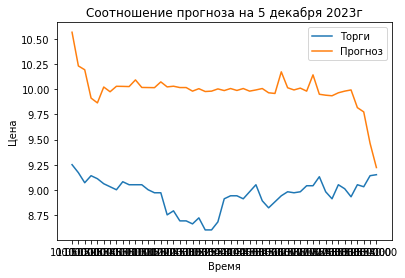

In [104]:
# Рисуем график прогноза и реальной цены

plt.plot(val_tik['tradetime'], val_tik['pr_close'], label='Торги')
plt.plot(val_tik['tradetime'], val_tik['PrognozValAbs'], label='Прогноз')
plt.legend()
plt.title('Соотношение прогноза на 5 декабря 2023г')
plt.xlabel('Время')
plt.ylabel('Цена')
plt.show()






In [105]:
# Точность модели по выбранному тикету (по абсолютной цене)
mean_absolute_percentage_error(val_tik['pr_close'], val_tik['PrognozValAbs'])

0.11560849629955043

In [106]:
# Точность модели по выбранному тикету (по нормализации)

mean_absolute_percentage_error(val_tik['Normpr_close'], val_tik['PrognozVal'])

0.14377945086693175

In [107]:
val_tik['PrognozValAbs'].max()

10.568999698671693

In [108]:
# Прогнозируемая доходность вложения, в процентах
((val_tik['PrognozValAbs'].max()/val_tik['PrognozValAbs'].min())-1)*100

14.61656811028238

In [109]:
val_tik['PrognozValAbs'].max()

10.568999698671693

In [110]:
val_tik['PrognozValAbs'].min()

9.221179688875658

In [111]:
# Теперь прогноз на следующую сессию, 6 декабря
val_all=val[columns_to_train]
y_prog=model_test.predict(val_all)
val['PrognozNew']=y_prog


In [112]:
# Вернем цены из нормализации 
val['PrognozNewAbs']=val['PrognozNew']*(val['pr_close_Max']-val['pr_close_Min'])+val['pr_close_Min']

In [113]:
# Выберем отдельный тикет (в приложении - по всем тикетам циклом)
val_new_tik=val.loc[val['ticker']=='ZVEZ']

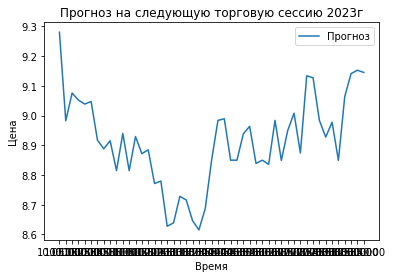

In [114]:
# Рисуем график прогноза и реальной цены

plt.plot(val_new_tik['tradetime'], val_new_tik['PrognozNewAbs'], label='Прогноз')
plt.legend()
plt.title('Прогноз на следующую торговую сессию 2023г')
plt.xlabel('Время')
plt.ylabel('Цена')
plt.show()



In [ ]:
## Также можно обозначить максимум, минимум дневного прогноза и предлагаемую доходность